In [1]:
import numpy as np
import pandas as pd
rng = np.random.default_rng(42)

from lymph.models import Unilateral
from lymixture import LymphMixture
from lymixture.utils import binom_pmf, late_binomial, normalize

dataset = pd.read_csv('../../data/mixture_model_data_combined_complete.csv', header = [0,1,2],)
dataset_staging = dataset.copy()
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([0,1,2], 'early')
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([3,4], 'late')
dataset_staging = dataset_staging[~(dataset_staging['tumor']['1']['subsite'].str.startswith(('C00.4')))]

/tmp/ipykernel_22349/451794406.py:9: DtypeWarning: Columns (4,5,12,13,14,15,16,17,18,19,20,35,37,38,39,45,47,48,49,56,62,63,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,93,94,95,97,98,99,101,104,105,107,108,111,112,113,114,115,116,117,118,119,120,121,122,126,127,128,129,130,131,132,133,134,135,136,150,164,179,193,208,222,227,228,229,230,231,232,233,234,235,236,237,238,242,243,244,245,246,247,248,249,250,251,252,272,274,276,278,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,357,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('../../data/mixture_model_data_combined_complete.csv', header = [0,1,2],)


In [2]:
dataset_staging_main_groups = dataset_staging.copy()

# Reduce to only main subsite
dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')] = (
    dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')].str.replace(r'\..*', '', regex=True)
)

dataset_staging_main_groups['tumor']['1']['subsite'].value_counts()


subsite
C32    1128
C09     452
C12     227
C01     212
C10     169
C13     165
C02     158
C04      99
C05      61
C06      46
C03      45
Name: count, dtype: int64

In [3]:
graph = {
    ("tumor", "T"): ["I", "II", "III", "IV", "V"],
    ("lnl", "I"): ["II"],
    ("lnl", "II"): ["III"],
    ("lnl", "III"): ["IV"],
    ("lnl", "IV"): ["V"],
    ("lnl", "V"): [],
}

num_components = 4

mixture = LymphMixture(
    model_cls=Unilateral,
    model_kwargs={"graph_dict": graph},
    num_components=num_components,
    universal_p= False
)
# mixture.load_patient_data(
#     dataset_staging_main_groups,
#     split_by=("tumor", "1", "subsite"),
#     mapping=lambda x: x,
# )


In [4]:
mixture.load_patient_data(
    dataset_staging_main_groups,
    split_by=("tumor", "1", "subsite"),
    mapping=lambda x: x,
)

In [5]:
mixture.patient_data

index                     patient                            \
                                     #                             
                           institution     sex age diagnose_date   
0      979  University Hospital Zurich    male  59    2017-08-30   
1     1105  University Hospital Zurich    male  51    2017-02-13   
2     1106  University Hospital Zurich    male  65    2014-02-03   
3     1135  University Hospital Zurich    male  56    2014-04-21   
4     1136  University Hospital Zurich    male  35    2014-05-08   
...    ...                         ...     ...  ..           ...   
2757  2582            Inselspital Bern    male  59    2018-08-22   
2758  2583            Inselspital Bern    male  60    2017-04-25   
2759  2584            Inselspital Bern    male  55    2015-05-05   
2760  2585            Inselspital Bern  female  72    2015-01-27   
2761  2586            Inselspital Bern    male  54    2010-08-31   

                                                                         ...  \
                                                                         ...   
     alcohol_abuse nicotine_abuse pack_years hpv_status neck_dissection  ...   
0             True           True        NaN       True           False  ...   
1             True           True        NaN       True           False  ...   
2             True           True        NaN       True           False  ...   
3             True           True        NaN       True           False  ...   
4             True           True        NaN       True           False  ...   
...            ...            ...        ...        ...             ...  ...   
2757          True           True        NaN      False            True  ...   
2758          True           True        NaN      False            True  ...   
2759         False           True        NaN       True            True  ...   
2760         False           True        NaN       True            True  ...   
2761         False           True        NaN       True            True  ...   

            _model                                                           \
     extracapsular                diagnostic_consensus                        
                II  III   IV    V                    I     II    III     IV   
0              NaN  NaN  NaN  NaN                False   True  False  False   
1              NaN  NaN  NaN  NaN                False   True   True  False   
2              NaN  NaN  NaN  NaN                False   True  False  False   
3              NaN  NaN  NaN  NaN                False   True   True   True   
4              NaN  NaN  NaN  NaN                False   True  False  False   
...            ...  ...  ...  ...                  ...    ...    ...    ...   
2757           NaN  NaN  NaN  NaN                False  False  False  False   
2758           NaN  NaN  NaN  NaN                False   True   True  False   
2759           NaN  NaN  NaN  NaN                False  False  False  False   
2760           NaN  NaN  NaN  NaN                 True  False   True  False   
2761           NaN  NaN  NaN  NaN                False  False  False  False   

                     
                  #  
          V t_stage  
0     False    late  
1     False    late  
2     False    late  
3      True    late  
4     False   early  
...     ...     ...  
2757  False    late  
2758  False   early  
2759  False    late  
2760  False   early  
2761  False   early  

[2762 rows x 492 columns]

In [6]:
mixture.set_distribution("early", binom_pmf(np.arange(11), 10, 0.3))
mixture.set_distribution("late", late_binomial)
mixture.set_modality("diagnostic_consensus", 1., 1.)

In [7]:
mixture.subgroups.keys()

dict_keys(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C09', 'C10', 'C12', 'C13', 'C32'])

Initialize random model parameters and latent variables/responsibilities.

In [8]:
from lymixture.em import expectation, maximization

params = {k: rng.uniform() for k in mixture.get_params()}

mixture.set_params(**params)
mixture.normalize_mixture_coefs()
latent = normalize(rng.uniform(size=mixture.get_resps().shape).T, axis=0).T

In [9]:
def to_numpy(params: dict[str, float]) -> np.ndarray:
    return np.array([p for p in params.values()])

In [10]:
mixture.get_mixture_coefs()

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13,C32
0,0.157173,0.469071,0.321792,0.347650,0.252842,0.153236,0.283822,0.059666,0.321756,0.268344,0.326343
1,0.410106,0.164913,0.185149,0.198406,0.108040,0.087611,0.243454,0.212150,0.260402,0.185711,0.358453
2,0.333560,0.336507,0.352429,0.329889,0.261682,0.383524,0.071545,0.107080,0.259853,0.200132,0.243324
3,0.099162,0.029509,0.140630,0.124055,0.377436,0.375629,0.401179,0.621103,0.157990,0.345813,0.071879


Iterate the computation of the expectation value of the latent variables (E-step) and the maximization of the (complete) data log-likelihood w.r.t. the model parameters (M-step).

In [11]:
def check_convergence(params_history, likelihood_history, steps_back_list):
    current_params = params_history[-1]
    current_likelihood = likelihood_history[-1]
    for steps_back in steps_back_list:
        previous_params = params_history[-steps_back - 1]
        if np.allclose(to_numpy(current_params), to_numpy(previous_params)):
            print('stopped due to parameter similarity')
            return True  # Return True if any of the steps is close
        elif (np.isclose(current_likelihood, likelihood_history[-steps_back - 1],rtol = 0, atol = 0.01)) and np.all(current_likelihood >= np.array(likelihood_history)):
            print('stopped due to likelihood similarity')
            return True
    return False

In [13]:
is_converged = False
count = 0
params_history = []
likelihood_history = []
params_history.append(params.copy())
likelihood_history.append(mixture.likelihood(use_complete=False))
# Number of steps to look back for convergence
look_back_steps = 3

while not is_converged:
    print(count)
    print(likelihood_history[-1])
    old_params = params
    latent = expectation(mixture, params)
    params = maximization(mixture, latent)
    
    # Append current params and likelihood to history
    params_history.append(params.copy())
    likelihood_history.append(mixture.likelihood(use_complete=False))
    
    # Check if converged
    if count >= 3:  # Ensure enough history is available
        is_converged = check_convergence(params_history, likelihood_history,list(range(1,look_back_steps+1)))
    count += 1

0
-14413.61927544002
1
-5092.795012188914
2
-4898.196193898188
3
-4799.329564490926
4
-4708.920407993129
5
-4635.687813343921
6
-4588.577515222151
7
-4561.757494081264
8
-4548.533680281196
9
-4540.434449147057
10
-4535.057661186773
11
-4531.303414674099
12
-4528.6395285049675
13
-4526.6632735323055
14
-4525.121704352012
15
-4523.891301615648
16
-4522.912659649468
17
-4522.103060332325
18
-4521.435487343171
19
-4520.870453725798
20
-4520.3905915816995
21
-4519.992130034423
22
-4519.661082080502
23
-4519.377932718195
24
-4519.1337599915305
25
-4518.914574368046
26
-4518.709222771711
27
-4518.531737605281
28
-4518.373433158455
29
-4518.229365044614
30
-4518.094726116171
31
-4517.972752753241
32
-4517.8557344034925
33
-4517.747620550363
34
-4517.6421936628
35
-4517.546477409198
36
-4517.454874381718
37
-4517.368769170753
38
-4517.286850039556
39
-4517.209267968456
40
-4517.135259342477
41
-4517.065257769557
42
-4516.998893417392
43
-4516.936230079079
44
-4516.878028917448
45
-4516.82535834

In [14]:
likelihood_history

[-14413.61927544002,
 -5092.795012188914,
 -4898.196193898188,
 -4799.329564490926,
 -4708.920407993129,
 -4635.687813343921,
 -4588.577515222151,
 -4561.757494081264,
 -4548.533680281196,
 -4540.434449147057,
 -4535.057661186773,
 -4531.303414674099,
 -4528.6395285049675,
 -4526.6632735323055,
 -4525.121704352012,
 -4523.891301615648,
 -4522.912659649468,
 -4522.103060332325,
 -4521.435487343171,
 -4520.870453725798,
 -4520.3905915816995,
 -4519.992130034423,
 -4519.661082080502,
 -4519.377932718195,
 -4519.1337599915305,
 -4518.914574368046,
 -4518.709222771711,
 -4518.531737605281,
 -4518.373433158455,
 -4518.229365044614,
 -4518.094726116171,
 -4517.972752753241,
 -4517.8557344034925,
 -4517.747620550363,
 -4517.6421936628,
 -4517.546477409198,
 -4517.454874381718,
 -4517.368769170753,
 -4517.286850039556,
 -4517.209267968456,
 -4517.135259342477,
 -4517.065257769557,
 -4516.998893417392,
 -4516.936230079079,
 -4516.878028917448,
 -4516.825358349006,
 -4516.778248102139,
 -4516.732

In [12]:
import json

# Saving the list of dictionaries to a file
# with open('params_history_4_comp_split_t_stage_add_larynx.json', 'w') as f:
#     json.dump(params_history, f, indent=4)

# Loading the list of dictionaries from the file
with open('params_history_4_comp_split_t_stage_add_larynx.json', 'r') as f:
    params_history_loaded = json.load(f)

In [13]:
# a = np.array(likelihood_history)
# np.savetxt('likelihoods_4_comp_split_t_stage_add_larynx.txt', a, fmt='%.6f')
b = np.loadtxt('likelihoods_4_comp_split_t_stage_add_larynx.txt', dtype=float)
b


array([-14413.619275,  -5092.795012,  -4898.196194,  -4799.329564,
        -4708.920408,  -4635.687813,  -4588.577515,  -4561.757494,
        -4548.53368 ,  -4540.434449,  -4535.057661,  -4531.303415,
        -4528.639529,  -4526.663274,  -4525.121704,  -4523.891302,
        -4522.91266 ,  -4522.10306 ,  -4521.435487,  -4520.870454,
        -4520.390592,  -4519.99213 ,  -4519.661082,  -4519.377933,
        -4519.13376 ,  -4518.914574,  -4518.709223,  -4518.531738,
        -4518.373433,  -4518.229365,  -4518.094726,  -4517.972753,
        -4517.855734,  -4517.747621,  -4517.642194,  -4517.546477,
        -4517.454874,  -4517.368769,  -4517.28685 ,  -4517.209268,
        -4517.135259,  -4517.065258,  -4516.998893,  -4516.93623 ,
        -4516.878029,  -4516.825358,  -4516.778248,  -4516.732793,
        -4516.689803,  -4516.648533,  -4516.608423,  -4516.569763,
        -4516.53281 ,  -4516.497355,  -4516.463271,  -4516.430148,
        -4516.397246,  -4516.363556,  -4516.330187,  -4516.297

In [16]:
likelihood_history = b

In [17]:
params_history = params_history_loaded

In [18]:
differences = []
for i in range(len(params_history)-1):
    differences.append(np.abs(np.array(list(params_history[i].values())) - np.array(list(params_history[i+1].values()))).sum())
differences

[29.491009577163613,
 2.7657971254849794,
 2.0560503795322265,
 1.7473957458882636,
 1.5698265707975285,
 1.357532142004269,
 1.1526179047062826,
 0.7010777166115371,
 0.6724791387102432,
 0.7026199731087933,
 0.6694032684063744,
 0.5181948131911406,
 0.28690132499804405,
 0.22310758804436615,
 0.19870866360961945,
 0.17697048119362366,
 0.1586154358842639,
 0.1419460451930603,
 0.1285067323997318,
 0.11638786489150635,
 0.10591840366730038,
 0.09651259717889071,
 0.08981752415919746,
 0.08327934123801618,
 0.07804433119675072,
 0.07395018822222393,
 0.07055120408629387,
 0.06840761130256634,
 0.06684897479484402,
 0.06586064793387916,
 0.06542193494196535,
 0.06522281178838883,
 0.06569816173945194,
 0.06655448400612496,
 0.06897366852861142,
 0.0701493877638266,
 0.07340844939225208,
 0.07759890734869498,
 0.08301018480782417,
 0.08949285204096011,
 0.09809737509795449,
 0.10698438918530899,
 0.1187276149071569,
 0.13088509128772047,
 0.08256060217027661,
 0.025913087552808793,
 0.02

Text(0.5, 1.0, 'Convergence of EM algorithm 4 comp 4 locs')

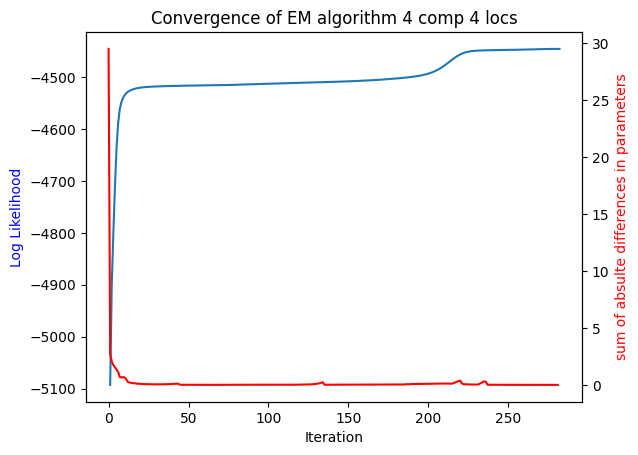

In [19]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(np.array(range(len(likelihood_history[1:])))+1,likelihood_history[1:])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Log Likelihood', color='blue')
ax2 = ax1.twinx()
ax2.plot(differences, color='red')  
ax2.set_ylabel('sum of absulte differences in parameters', color='red')
ax1.set_title('Convergence of EM algorithm 4 comp 4 locs')

In [13]:
params = params_history[np.argmax(likelihood_history)]
mixture.set_params(**params)
mixture.normalize_mixture_coefs()
latent = normalize(rng.uniform(size=mixture.get_resps().shape).T, axis=0).T

NameError: name 'params_history' is not defined

In [51]:
mixture.likelihood(use_complete=False)

-4445.893869039734

In [52]:
mixture._mixture_coefs

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13,C32
0,0.109564,0.254035,2.160200e-72,1.694505e-08,0.109708,3.012856e-43,0.185110,0.307064,1.548275e-01,2.727559e-01,9.087564e-01
1,0.152224,0.098971,5.788417e-181,3.858595e-02,0.069108,1.526296e-64,0.199941,0.243556,8.451317e-01,7.241774e-01,8.481235e-02
2,0.027593,0.450016,9.999573e-01,8.692428e-01,0.499755,9.445527e-01,0.048209,0.068002,2.303825e-16,1.239928e-22,6.431276e-03
3,0.710619,0.196978,4.265009e-05,9.217120e-02,0.321428,5.544734e-02,0.566740,0.381378,4.083013e-05,3.066768e-03,2.040915e-27


In [20]:
mixture.get_params()

{'0_TtoI_spread': 6.610696135189607e-05,
 '0_TtoII_spread': 0.030579532156417125,
 '0_TtoIII_spread': 0.009476103925137614,
 '0_TtoIV_spread': 0.0022335702628745904,
 '0_TtoV_spread': 0.0019527120593273797,
 '0_ItoII_spread': 0.9999339146354761,
 '0_IItoIII_spread': 0.10592134489142861,
 '0_IIItoIV_spread': 0.026839222654974158,
 '0_IVtoV_spread': 0.015083098230513913,
 '0_late_p': 0.9999404458837985,
 '0_C01_coef': 0.10956399071991957,
 '0_C02_coef': 0.2540346959300936,
 '0_C03_coef': 2.1602004817134456e-72,
 '0_C04_coef': 1.6945052278009505e-08,
 '0_C05_coef': 0.10970832366405617,
 '0_C06_coef': 3.0128558711504365e-43,
 '0_C09_coef': 0.18510956117908137,
 '0_C10_coef': 0.30706413784215675,
 '0_C12_coef': 0.1548275132489901,
 '0_C13_coef': 0.27275585865833063,
 '0_C32_coef': 0.9087563772225042,
 '1_TtoI_spread': 0.02186806033610476,
 '1_TtoII_spread': 0.3961597720717774,
 '1_TtoIII_spread': 0.2960978475018013,
 '1_TtoIV_spread': 0.08086941515646148,
 '1_TtoV_spread': 0.046916101379945

In [53]:
subgroup = 'C32'
t_stage = 'early'
desired_lnl = 'II'
lnls = np.array(['I','II','III','IV','V'])
involvement = {'I': None, 'II': None, 'III': None, 'IV': None, 'V': None}



subgroup_combinations_short = pd.DataFrame(mixture.subgroups[subgroup].patient_data['_model']['diagnostic_consensus'].loc[mixture.subgroups[subgroup].patient_data['_model']['#']['t_stage'] == t_stage].value_counts()/((mixture.subgroups[subgroup].patient_data['_model']['#']['t_stage'] == t_stage) & (np.all(mixture.subgroups[subgroup].patient_data['_model']['diagnostic_consensus'].notna(),axis = 1))).sum().sum())
# Convert the Series to DataFrame
df = subgroup_combinations_short.reset_index()
df.columns = ['I', 'II', 'III', 'IV', 'V', 'prevalence']

# Convert boolean columns to tuples
df['predicted'] = df[['I', 'II', 'III', 'IV', 'V']].apply(lambda row: tuple(int(x) for x in row), axis=1)

# Drop the original boolean columns
df = df.drop(columns=['I', 'II', 'III', 'IV', 'V'])

import itertools

# Define the number of features (length of the combination list)
num_features = 5  # Update based on your data length

# Generate all possible combinations of binary values (0 or 1)
combinations = list(itertools.product([0, 1], repeat=num_features))

# Create a DataFrame with all combinations and default probability of 0
subgroup_combinations = pd.DataFrame(combinations, columns=[f'Feature_{i+1}' for i in range(num_features)])
subgroup_combinations['predicted'] = subgroup_combinations.apply(lambda row: tuple(row), axis=1)
subgroup_combinations.drop(columns=[f'Feature_{i+1}' for i in range(num_features)], inplace=True)
# Merge with the existing probabilities
subgroup_combinations = pd.merge(subgroup_combinations, df, on='predicted', how='left').fillna(0)
subgroup_combinations.drop(columns=['predicted'], inplace=True)

mixture.state_dist(subgroup=subgroup)
df = pd.DataFrame(np.array([mixture.state_dist(subgroup=subgroup,t_stage=t_stage)]), columns = [str(col) for col in mixture.components[0].graph.state_list])
df = df.T
df.columns = ['predicted']
subgroup_combinations['index'] = df.index
subgroup_combinations.set_index('index', inplace=True)
df_final = pd.concat([subgroup_combinations, df],axis = 1)
df_final['difference'] = df_final['predicted'] - df_final['prevalence']

lnl_index = np.where(lnls == desired_lnl)[0][0]
indices = []
for i, state in enumerate(mixture.components[0].graph.state_list):
    if state[lnl_index] == 1:
        indices.append(i)
print(desired_lnl, subgroup_combinations.iloc[indices].sum()*100,)
involvement[desired_lnl] = True
print('predicted involvement of', desired_lnl, mixture.risk(subgroup=subgroup, t_stage=t_stage, involvement=involvement)*100)

(df_final*100)

II prevalence    8.823529
dtype: float64
predicted involvement of II 14.164875938251317


,prevalence,predicted,difference
[0 0 0 0 0],88.419118,81.080187,-7.338931
[0 0 0 0 1],0.183824,0.523937,0.340113
[0 0 0 1 0],0.367647,0.636336,0.268689
[0 0 0 1 1],0.000000,0.035566,0.035566
[0 0 1 0 0],1.470588,2.911889,1.441301
[0 0 1 0 1],0.000000,0.105961,0.105961
[0 0 1 1 0],0.367647,0.281648,-0.085999
[0 0 1 1 1],0.000000,0.050450,0.050450
[0 1 0 0 0],4.227941,7.995057,3.767116
[0 1 0 0 1],0.183824,0.228607,0.044783


## Load/Save Data

In [9]:
import pickle 
from lymixture.em import expectation, maximization

# with open('params_I_to_V_ipsi_4_comp_split_t_stages_add_larynx.pkl', 'wb') as f:
#     pickle.dump(params, f)
        
with open('params_I_to_V_ipsi_4_comp_split_t_stages_add_larynx.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
params = loaded_dict
mixture.set_params(**loaded_dict)
mixture.normalize_mixture_coefs()
mixture.set_resps(expectation(mixture, loaded_dict))
mixture.likelihood(use_complete= False)

-4445.893869039734

In [10]:
mixture.likelihood(use_complete= True)


-5549.160598690072

In [11]:
mixture.get_mixture_coefs()

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13,C32
0,0.109564,0.254035,2.160200e-72,1.694505e-08,0.109708,3.012856e-43,0.185110,0.307064,1.548275e-01,2.727559e-01,9.087564e-01
1,0.152224,0.098971,5.788417e-181,3.858595e-02,0.069108,1.526296e-64,0.199941,0.243556,8.451317e-01,7.241774e-01,8.481235e-02
2,0.027593,0.450016,9.999573e-01,8.692428e-01,0.499755,9.445527e-01,0.048209,0.068002,2.303825e-16,1.239928e-22,6.431276e-03
3,0.710619,0.196978,4.265009e-05,9.217120e-02,0.321428,5.544734e-02,0.566740,0.381378,4.083013e-05,3.066768e-03,2.040915e-27


## Mixture evaluation

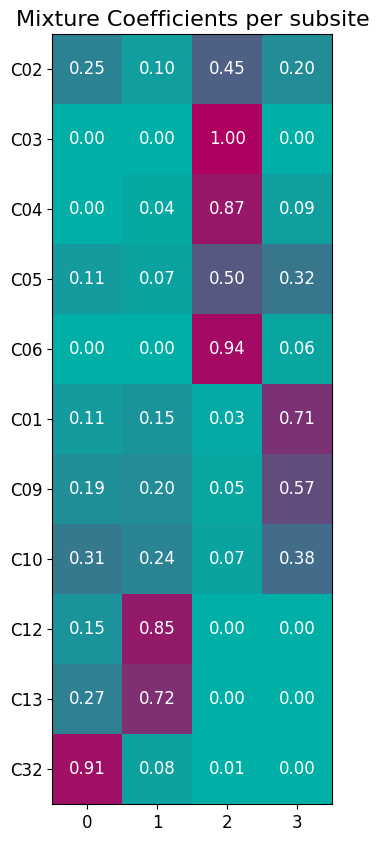

In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

# USZ colors
usz_blue = '#005ea8'
usz_green = '#00afa5'
usz_red = '#ae0060'
usz_orange = '#f17900'
usz_gray = '#c5d5db'

# colormaps
white_to_blue  = LinearSegmentedColormap.from_list("white_to_blue", 
                                                   ["#ffffff", usz_blue], 
                                                   N=256)
white_to_green = LinearSegmentedColormap.from_list("white_to_green", 
                                                   ["#ffffff", usz_green], 
                                                   N=256)
green_to_red   = LinearSegmentedColormap.from_list("green_to_red", 
                                                   [usz_green, usz_red], 
                                                   N=256)

h = usz_gray.lstrip('#')
gray_rgba = tuple(int(h[i:i+2], 16) / 255. for i in (0, 2, 4)) + (1.0,)
tmp = LinearSegmentedColormap.from_list("tmp", [usz_green, usz_red], N=128)

matrix = mixture.get_mixture_coefs()[['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13','C32']]

# Transpose the matrix to rotate by 90°
matrix_rotated = matrix.T

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 10))

# Display the rotated matrix using imshow
cax = ax.imshow(matrix_rotated.values, cmap=tmp, origin='upper')

# Loop over the data and create text annotations
for i in range(matrix_rotated.shape[0]):  # Rows (previously columns)
    for j in range(matrix_rotated.shape[1]):  # Columns (previously rows)
        value = matrix_rotated.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", 
                color="white", fontsize=12)


# Optional: Set axis labels and title
ax.set_xticks(range(matrix_rotated.shape[1]))
ax.set_xticklabels(matrix.index, fontsize = 12)  # Original row labels
ax.set_yticks(range(matrix_rotated.shape[0]))
ax.set_yticklabels(matrix.columns, fontsize = 12)  # Original column labels
ax.set_title("Mixture Coefficients per subsite", fontsize = 16)
plt.show()


In [13]:
params

{'0_TtoI_spread': 6.610696135189607e-05,
 '0_TtoII_spread': 0.030579532156417125,
 '0_TtoIII_spread': 0.009476103925137614,
 '0_TtoIV_spread': 0.0022335702628745904,
 '0_TtoV_spread': 0.0019527120593273797,
 '0_ItoII_spread': 0.9999339146354761,
 '0_IItoIII_spread': 0.10592134489142861,
 '0_IIItoIV_spread': 0.026839222654974158,
 '0_IVtoV_spread': 0.015083098230513913,
 '0_late_p': 0.9999404458837985,
 '0_C01_coef': 0.10956399071991957,
 '0_C02_coef': 0.2540346959300936,
 '0_C03_coef': 2.1602004817134456e-72,
 '0_C04_coef': 1.6945052278009505e-08,
 '0_C05_coef': 0.10970832366405617,
 '0_C06_coef': 3.0128558711504365e-43,
 '0_C09_coef': 0.18510956117908137,
 '0_C10_coef': 0.30706413784215675,
 '0_C12_coef': 0.1548275132489901,
 '0_C13_coef': 0.27275585865833063,
 '0_C32_coef': 0.9087563772225042,
 '1_TtoI_spread': 0.02186806033610476,
 '1_TtoII_spread': 0.3961597720717774,
 '1_TtoIII_spread': 0.2960978475018013,
 '1_TtoIV_spread': 0.08086941515646148,
 '1_TtoV_spread': 0.046916101379945

## 3d Simplex plot

In [28]:
import math
def p_to_xyz(p):
    #Project 4D representation down to 3D representation
    s3 = 1/math.sqrt(3.0)
    s6 = 1/math.sqrt(6.0)
    x =  -1*p[0] +  1*p[1] +    0*p[2] +    0*p[3]
    y = -s3*p[0] - s3*p[1] + 2*s3*p[2] +    0*p[3]
    z = -s3*p[0] - s3*p[1] -   s3*p[2] + 3*s6*p[3]
    return x, y, z

def add_perpendicular_crosses_3d(ax, x1, y1, z1, x2, y2, z2, tick_length=0.03):
    num_ticks = 6  # Number of ticks
    for i in range(num_ticks):
        t = i / (num_ticks - 1)
        
        # Interpolation point (x, y, z) on the line
        x_tick = x1 + t * (x2 - x1)
        y_tick = y1 + t * (y2 - y1)
        z_tick = z1 + t * (z2 - z1)
        
        # Vector along the line (direction of the line)
        line_vec = np.array([x2 - x1, y2 - y1, z2 - z1])
        
        # First perpendicular vector (cross product with z-axis)
        perp_vec1 = np.cross(line_vec, [0, 0, 1])
        length1 = np.linalg.norm(perp_vec1)
        if length1 == 0:  # Prevent division by zero (in rare cases when parallel to z-axis)
            perp_vec1 = np.cross(line_vec, [1, 0, 0])  # Cross with x-axis instead
            length1 = np.linalg.norm(perp_vec1)
        perp_vec1 /= length1  # Normalize
        
        # Second perpendicular vector (cross product with line_vec and perp_vec1)
        perp_vec2 = np.cross(line_vec, perp_vec1)
        perp_vec2 /= np.linalg.norm(perp_vec2)  # Normalize
        
        # Scale the perpendicular vectors by tick length
        perp_vec1 *= tick_length
        perp_vec2 *= tick_length
        
        # Draw the cross (two perpendicular lines)
        ax.plot([x_tick - perp_vec1[0], x_tick + perp_vec1[0]],
                [y_tick - perp_vec1[1], y_tick + perp_vec1[1]],
                [z_tick - perp_vec1[2], z_tick + perp_vec1[2]], color='gray', linewidth=0.8)
        
        ax.plot([x_tick - perp_vec2[0], x_tick + perp_vec2[0]],
                [y_tick - perp_vec2[1], y_tick + perp_vec2[1]],
                [z_tick - perp_vec2[2], z_tick + perp_vec2[2]], color='gray', linewidth=0.8)
        
        ax.text(x_tick, y_tick, z_tick, f'{int(100 - t * 100)}%', fontsize=6, ha='right', va='bottom')


In [16]:

blue_to_white = LinearSegmentedColormap.from_list("blue to white", 
                                                   [usz_blue, "#ffffff"], 
                                                   N=256)
green_to_white = LinearSegmentedColormap.from_list("green_to_white", 
                                                   [usz_green, "#ffffff"], 
                                                   N=256)
red_to_white   = LinearSegmentedColormap.from_list("red_to_white", 
                                                   [usz_red, "#ffffff"], 
                                                   N=256)
orange_to_white   = LinearSegmentedColormap.from_list("orange_to_white", 
                                                   [usz_orange, "#ffffff"], 
                                                   N=256)
colors_ordered= [
    blue_to_white(0), blue_to_white(0.15), blue_to_white(0.3), 
    blue_to_white(0.45), blue_to_white(0.6), green_to_white(0), 
    green_to_white(0.3), green_to_white(0.6), red_to_white(0), 
    red_to_white(0.5), orange_to_white(0)
]

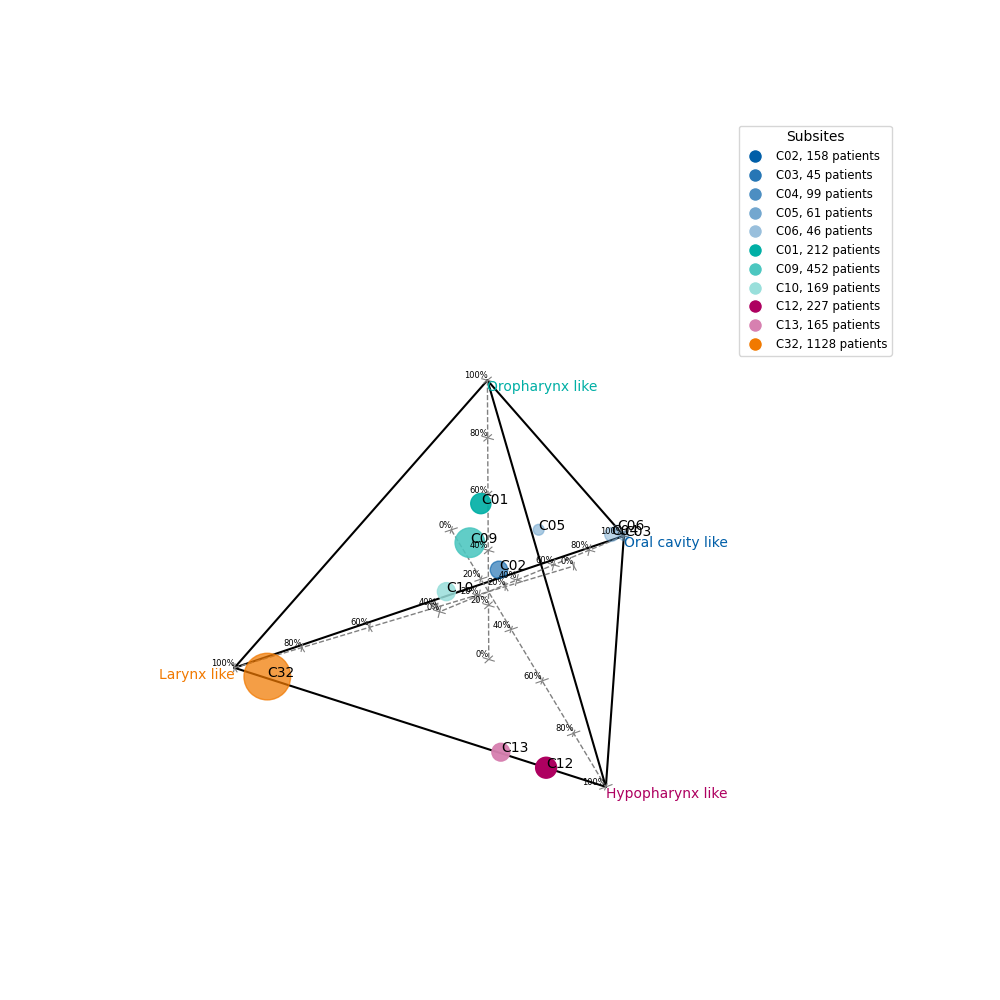

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

%matplotlib widget

subsites = ['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13','C32']
simplex_matrix = np.zeros((len(subsites), 3))
for index, subsite in enumerate(subsites):
    simplex_matrix[index] = p_to_xyz(matrix[subsite])
odered_value_counts = dataset_staging_main_groups['tumor']['1']['subsite'].value_counts()[['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13', 'C32']]
sizes = odered_value_counts * 3

# Sizes for each point
ordered_value_counts = dataset_staging_main_groups['tumor']['1']['subsite'].value_counts()[subsites]
sizes = np.array(ordered_value_counts) * 1  # Adjust the scaling if necessary

# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Extract coordinates from simplex_matrix
x_coords = simplex_matrix[:, 0]
y_coords = simplex_matrix[:, 1]
z_coords = simplex_matrix[:, 2]

# Scatter plot with specific colors and sizes
scatter = ax.scatter(x_coords, y_coords, z_coords, c=colors_ordered, s=sizes, marker='o')

# Add text labels for each subsite
for i, subsite in enumerate(subsites):
    ax.text(x_coords[i], y_coords[i], z_coords[i], subsite)
    x_extremes = [-1,1,0,0]
    y_extremes = [-0.5773502691896258,-0.5773502691896258,1.1547005383792517,0]
    z_extremes = [-0.5773502691896258,-0.5773502691896258,-0.5773502691896258,1.2247448713915892]
plotter_x = x_extremes.copy()
plotter_x.append(x_extremes[0])
plotter_x.append(x_extremes[2])
plotter_y = y_extremes.copy()
plotter_y.append(y_extremes[0])
plotter_y.append(y_extremes[2])
plotter_z = z_extremes.copy()
plotter_z.append(z_extremes[0])
plotter_z.append(z_extremes[2])

ax.plot(plotter_x, plotter_y,plotter_z, c='k')
ax.plot([x_extremes[1],x_extremes[3]], [y_extremes[1],y_extremes[3]],[z_extremes[1],z_extremes[3]], c='k')
extremes = np.array((x_extremes,y_extremes,z_extremes)).T
center0 = (extremes[1]+extremes[2]+extremes[3])/3
center1 = (extremes[0]+extremes[2]+extremes[3])/3
center2 = (extremes[0]+extremes[1]+extremes[3])/3
center3 = (extremes[0]+extremes[1]+extremes[2])/3

component_larynx = mixture.get_mixture_coefs()['C32'].argmax()
component_oropharynx = mixture.get_mixture_coefs()['C01'].argmax()
component_oral_cavity = mixture.get_mixture_coefs()['C03'].argmax()
component_hypopharynx = mixture.get_mixture_coefs()['C13'].argmax()

ax.text(extremes[component_larynx,0], extremes[component_larynx,1], extremes[component_larynx,2], "Larynx like", fontsize=10, ha='right', va='top',c = usz_orange)
ax.text(extremes[component_oropharynx,0], extremes[component_oropharynx,1], extremes[component_oropharynx,2], "Oropharynx like", fontsize=10, ha='left', va='top',c = usz_green)
ax.text(extremes[component_oral_cavity,0], extremes[component_oral_cavity,1], extremes[component_oral_cavity,2], "Oral cavity like", fontsize=10, ha='left', va='top',c = usz_blue)
ax.text(extremes[component_hypopharynx,0], extremes[component_hypopharynx,1], extremes[component_hypopharynx,2], "Hypopharynx like", fontsize=10, ha='left', va='top',c = usz_red)



add_perpendicular_crosses_3d(ax, extremes[0, 0], extremes[0, 1], extremes[0, 2], center0[0], center0[1], center0[2])
plt.plot([extremes[0,0], center0[0]], [extremes[0,1], center0[1]],[extremes[0,2],center0[2]], color='gray', linestyle='--', linewidth=1)
add_perpendicular_crosses_3d(ax, extremes[1, 0], extremes[1, 1], extremes[1, 2], center1[0], center1[1], center1[2])
plt.plot([extremes[1,0], center1[0]], [extremes[1,1], center1[1]],[extremes[1,2],center1[2]], color='gray', linestyle='--', linewidth=1)
add_perpendicular_crosses_3d(ax, extremes[2, 0], extremes[2, 1], extremes[2, 2], center2[0], center2[1], center2[2])
plt.plot([extremes[2,0], center2[0]], [extremes[2,1], center2[1]],[extremes[2,2],center2[2]], color='gray', linestyle='--', linewidth=1)
add_perpendicular_crosses_3d(ax, extremes[3, 0], extremes[3, 1], extremes[3, 2], center3[0], center3[1], center3[2])
plt.plot([extremes[3,0], center3[0]], [extremes[3,1], center3[1]],[extremes[3,2],center3[2]], color='gray', linestyle='--', linewidth=1)

legend_text = []
for index in range(len(subsites)):
    legend_text.append(subsites[index] + ', ' + str(odered_value_counts[index]) + ' patients')

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=text)
                   for color, text in zip(colors_ordered, legend_text)]

# Add a legend with fixed dot sizes
plt.legend(handles=legend_elements, loc='upper right', title='Subsites', fontsize='small')

plt.gca().set_axis_off()
plt.show()
